# PyTorch и Многослойные нейронные сети

<img src="https://i2.wp.com/www.datahubbs.com/wp-content/uploads/2018/06/cropped_large_sn.png?w=790&ssl=1" width=600 align=center>




## 1. Введение

В данном ноутбуке мы познакомимся с фреймворком **PyTorch**. Как установить `pytorch` можно прочитать [здесь](http://pytorch.org/), для этого выберите свою OS и вам будет показана нужная команда для ввода в терминале.

### 1.1 Граф вычислений

`PyTorch` отличается от остальных библиотек таких как `TensorFlow/Theano`. В `TensorFlow/Theano` строися граф вычислений, после чего начинается обучение и данный граф вычислений применяется к разным входам. Граф вычислений можно понимать как рецепт, который знает как посчитать выход по какому-либо входу. В `Pytorch`-е все наоборот: здесь мы работаем с определенными тензорами, которые имеют определенные значения. На каждом этапе мы можем посмотреть на числиненные значения каждого из тензоров. Таким образом мы можем динамически строить граф вычислений менять структуру нейронной сети во время обучения. **UPD на Апрель 2020**: В `TensowFlow 2.0` и более поздних версиях граф по-умолчанию теперь тоже [строится динамически](https://www.tensorflow.org/guide/effective_tf2). а фреймворк `Keras` стал частью `TensorFlow`.

<img src="https://github.com/pytorch/pytorch/raw/master/docs/source/_static/img/dynamic_graph.gif" width=600 align=center>

Все результаты вычисляются на ходу без объявления графов заранее. Код выглядит практически точно так же, как в чистом виде, с одним исключением: `pytorch` вычисляет градиенты для вас и умеет делать `backpropagation`. Также `PyTorch` умеет запускаться на GPU и имеет ряд уже реализованных слоев для ваших нейронных сетей.

Для сравнения TensorFlow и Pytorch можно почитать [статью.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)


In [0]:
from collections import defaultdict
from collections import OrderedDict

import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import clear_output

from sklearn.datasets import load_boston

In [43]:
#!pip3 install torch
import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

print(torch.__version__)

1.4.0


### 1.2 NumPy-синтаксис

Посмотрим как производятся арифметические операции в numpy.

In [44]:
x = np.arange(16).reshape(4, 4)

print("X :\n{}\n".format(x))
print("X.shape : {}\n".format(x.shape))
print("add 5 :\n{}\n".format(x + 5))
print("X*X^T  :\n{}\n".format(np.dot(x, x.T)))
print("mean over cols :\n{}\n".format(x.mean(axis=-1)))
print("cumsum of cols :\n{}\n".format(np.cumsum(x, axis=0)))

X :
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

X.shape : (4, 4)

add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]

X*X^T  :
[[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]

mean over cols :
[ 1.5  5.5  9.5 13.5]

cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]



### 1.3 PyTorch-синтаксис

Теперь посмотрим на арифметические операции и pytorch. PyTorch работает с torch-тензорами (тензор - многомерный массив), с которыми можно производить те почти все те же операции, что и numpy-массивами.

In [45]:
x = np.arange(16).reshape(4, 4)

x = torch.tensor(x, dtype=torch.float32)  # или torch.arange(0,16).view(4,4)

print("X:\n{}".format(x))
print("X.shape: {}\n".format(x.shape))
print("add 5:\n{}".format(x + 5))
print("X*X^T:\n{}".format(torch.matmul(x, x.transpose(1, 0)))) # кратко: x.mm(x.t())
print(x @ x.transpose(1, 0))
print("mean over cols:\n{}".format(torch.mean(x, dim=-1)))
print("cumsum of cols:\n{}".format(torch.cumsum(x, dim=0)))

X:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
X.shape: torch.Size([4, 4])

add 5:
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T:
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols:
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


Как вы можете заметить написание кода на pytorch достаточно похоже на numpy. В каждый момент времени мы можем посмотреть на значения любого тензора, и для деббагинга такого кода удобно печатать значения этих тензоров.

Также, можно замететить, что всё же некоторые названия методов отличаются от numpy-евских. Полной совместимости с numpy пока нет и придется сново запоминать новые названия для некоторых методов.

Несколько примеров:

* Если в numpy метод принимает list/tuple номеров осей, то скорей всего в pytorch-е этот метод будет принимать *args
 * `x.reshape([1,2,8]) -> x.view(1,2,8)`
* В операциях, таких как sum, mean, cumsum параметр _`axis`_ заменяется на _`dim`_
 * `x.sum(axis=-1) -> x.sum(dim=-1)`
* Pytorch имеет другое написание стандартных типов
 * `x.astype('int64') -> x.type(torch.LongTensor)`


Для более подробного ознакомления можно посмотреть на [табличку](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users) перевода методов из numpy в pytorch, а также заглянуть в [документацию](http://pytorch.org/docs/master/). Также при возникновении проблем часто помогает зайти на [pytorch forumns](https://discuss.pytorch.org/).


## 2. Основы PyTorch

### 2.1 Разминка

Давайте нарисуем по сетке данную кривую на графике, используя pytorch:

$$ x(t) = 2 \cos t + \sin 2t \cos 60t$$
$$y(t) = \sin 2t + \sin 60t$$


Заметим, чтобы перевести numpy-массив в torch-тензор нужна одна функция. <br>
Например, это можно сделать так : `x = torch.tensor(x, dtype=torch.float32)`, или `x = torch.from_numpy(x, dtype=torch.float32)` <br>
Аналогично и с переводом обратно : `x.numpy()` переведет torch-тензор x в numpy-массив, причем типы переведутся соответственно табличке.

In [0]:
t = torch.linspace(-10, 10, steps=10000)

# вычислите x(t) и y(t)

######## ВАШ КОД ЗДЕСЬ ########

### 2.2 Работа с CUDA

Нам не всегда хочется работать на CPU. PyTorch умеет работать и с GPU (Graphical Processing Unit) тоже, для этого ему нужно об этом явно сказать. Например, чтобы создать копию переменной `t` на CUDA (GPU), нужно сделать  `t.cuda()` (вернет **копию** переменной, размещенную в видеопамяти GPU, а не в оперативной памяти CPU).

Если вы получаете ошибку `RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected`, то у вас или нет графической карты, или стоят старые драйвера для нее, или нет библиотеки CUDA.

*Примечание:* [CUDA](https://ru.wikipedia.org/wiki/CUDA) -- это библиотека от компании Nvidia, написанная на C/С++ и позволяющая работать с графическими процессорами (GPU) от Nvidia. В частности, быстро выполнять на них операции линейной алгебры (mat-vec умножение, mat-mat умножение, разложения матриц).



In [0]:
t = t.cuda()

In [48]:
t

tensor([-10.0000,  -9.9980,  -9.9960,  ...,   9.9960,   9.9980,  10.0000],
       device='cuda:0')

Если вы запускаетесь то на машинах с GPU, то на машинах с CPU, то для того, чтобы не исправлять код при переходе с одной машины на другую удобно создать device и переводить все тензоры в него при помощи `.to(device)`.

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t = t.to(device)

Чтобы перевести переменную с GPU на CPU обратно нужно сделать следующее: 

In [0]:
t = t.cpu()

In [51]:
t

tensor([-10.0000,  -9.9980,  -9.9960,  ...,   9.9960,   9.9980,  10.0000])

In [52]:
a = t.cuda()
a

tensor([-10.0000,  -9.9980,  -9.9960,  ...,   9.9960,   9.9980,  10.0000],
       device='cuda:0')

In [53]:
t

tensor([-10.0000,  -9.9980,  -9.9960,  ...,   9.9960,   9.9980,  10.0000])

Обратите внимание на то, что `torch.Tensor` и `torch.cuda.Tensor` $-$ разные классы, и при создании одного из другого будет создаваться копия:

In [54]:
cpu_tensor = torch.tensor([[1,2,3], [4,5,6]], device='cpu')
print(cpu_tensor.type())
print(cpu_tensor)

torch.LongTensor
tensor([[1, 2, 3],
        [4, 5, 6]])


In [55]:
gpu_tensor = cpu_tensor.cuda()
# или так
# device = 'cuda:0'
# gpu_tensor = cpu_tensor.to(device)
print(gpu_tensor.type())
print(gpu_tensor)

torch.cuda.LongTensor
tensor([[1, 2, 3],
        [4, 5, 6]], device='cuda:0')


In [56]:
cpu_tensor == gpu_tensor

RuntimeError: ignored

In [0]:
!nvidia-smi

### 2.3 Автоматический подсчет градиентов

#### 2.3.1 Recap: Цикл обучения модели

Пусть у нас есть вход $x \in \mathbb{R}^d$. Мы построили модель (нейронную сеть) $model$, состоящую из обучаемых весов $w$. На выходе модель возвращает некоторый ответ $\widehat{y} = model(x)$.
Для обучения такой сети мы задаем лосс, который будем минимизировать. 
Тогда процесс обучения задается так :
 * Forward pass <br>
     Считаем $\widehat{y}$ и также запоминаем значения выходов всех слоев; <br>
 * Вычисление эмпирического риска на текущем наборе объектов; <br>
 * Backward pass <br>
     Считаем градиенты по всем обучаемым параметрам и запоминаем их; <br>
 * Шаг оптимизации <br>
     Делаем шаг градиентного спуска, обновляя все обучаемые веса. <br>
    

На языке PyTorch этот пайплайн выглядит примерно так : 
* Создаем **обучаемые веса (тензоры)**. Также нужно не забыть проверить, что поле  `requires_grad` у тензоров этих весов `== True`. По-умолчанию при создании оно `False`:
    * ```torch.zeros(5, requires_grad=True)```
    * ```torch.tensor(np.arange(5), dtype=torch.float32, requires_grad=True)```
    * `my_tensor.requires_grad = True`
* Определяем **дифференцируемый** `loss = arbitrary_function(x)`. Здесь `arbitrary_function` - это функция, по которой мы получаем значение лосса, зная вход. То есть в случае нейронных сетей сюда по сути входит вся нейронная сеть + подсчет лосса по выходу нейронной сети
* Вызываем `loss.backward()`. Данная функция сделает **обратный проход** и посчитает (с помощью `autograd`) градиенты по каждому обучаемому (`requires_grad=True`) тензору и запомнит их внутри полей этих тензоров. При этом не делает сам шаг (обновление), он **только подсчитывает градиенты**
* После можно посмотреть на **значение градиента** для любого требующего градиента тензора `a`: `a.grad`
* Шаг оптимизации использует эти градиенты для **обновления весов** модели (как именно -- зависит от алгоритма)

**Примечание:** вообщя говоря, в вычисление `loss`'а могут входить не всюду дифференцируемые функции (например, ReLU), и формально loss дифференцируемым не будет. Однако при реализации такие функции обычно доопределяют в недифференцируемых точках, чтобы все же можно было сделать backpropagation.

#### 2.3.2 Пример: линейная регрессия

Сделаем одномерную линейную регрессию на датасете boston.

Скачиваем данные.

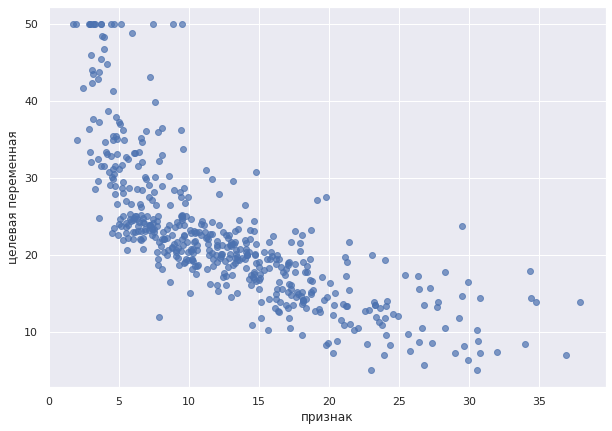

In [57]:
boston = load_boston()

plt.figure(figsize=(10,7))
plt.scatter(boston.data[:, -1], boston.target, alpha=0.7)
plt.xlabel('признак')
plt.ylabel('целевая переменная')
plt.grid(':');

В данном случае ответ модели задается следующим образом: $$\widehat{y}(x) = wx + w_0$$

Объявляем обучаемые переменные: тут у нас всего 2 скалярных параметра ($w, w_0$). Также задаем вход $x$ и отклики $y$ в виде torch-тензоров. 

In [0]:
w = torch.zeros(1, requires_grad=True)
w0 = torch.zeros(1, requires_grad=True)

x = torch.FloatTensor(boston.data[:, -1] / 10)
y = torch.FloatTensor(boston.target)

# по-другому:
# x = torch.tensor(boston.data[:, -1] / 10, dtype=torch.float32)
# y = torch.tensor(boston.target, dtype=torch.float32)

In [59]:
print(x.shape)
print(y.shape)

torch.Size([506])
torch.Size([506])


Задаем функцию потерь `loss` и сделаем обратный проход `loss.backward()`:

$$
\mathcal{L}(\widehat{y}, y) = \frac{1}{n} \sum_{i=1}^n (\widehat{y}_i - y_i)^2
$$

In [0]:
y_pred = w * x + w0

loss = torch.mean((y_pred - y)**2)

loss.backward()  #retrain_graph=True)

Наш лосс - это конкретное число, вычисленное на этой итерации.

In [61]:
loss

tensor(592.1471, grad_fn=<MeanBackward0>)

К градиентам для переменных, которые требуют градиента (`requires_grad=True`), теперь можно обратиться следующим образом:

In [62]:
print("dL/dw =", w.grad)
print("dL/dw0 =", w0.grad)

dL/dw = tensor([-47.3514])
dL/dw0 = tensor([-45.0656])


Если мы посчитаем градиент несколько раз (несколько раз вызовем `loss.backward()`), то градиент будет накапливаться (суммироваться) в переменных, требующих градиента. Иногда это бывает удобно, если мы, например, хотим усреднить градиенты по нескольким батчам. Тогда шаг градиентного спуска будет выглядеть так:

$$
w^{j+1} = w^j - \alpha \sum_{m=1}^M \left[\frac{\partial \mathcal{L}}{\partial w^j}\right]_m
$$

где $\left[\frac{\partial \mathcal{L}}{\partial w}\right]_m$ $-$ градиент лосса по параметру (весу) $w$ на $m$-ой итерации.

Если же мы не хотим, чтобы градиенты суммировались (а обычно мы не хотим), нужно **занулять градиенты** между итерациями после того как сделали шаг градиентного спуска.

Напишем код, обучающий нашу модель:

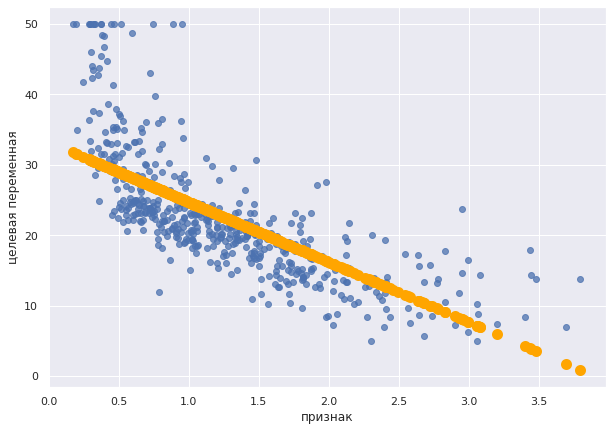

loss =  38.970345
Done!


In [63]:
num_epochs = 1000

lr_w = 0.01
lr_w0 = 0.05

for i in range(num_epochs):

    # Forward pass: предсказание модели
    y_pred = w1 * (w * x + w0)

    # Подсчет функции потерь
    loss = torch.mean((y_pred - y)**2)

    # Bakcward pass: подсчет градиентов
    loss.backward()

    # Оптимизация: обновение весов
    w.data -= lr_w * w.grad.data
    w0.data -= lr_w0 * w0.grad.data
    w1.data -=

    # зануление градиентов
    w.grad.data.zero_()
    w0.grad.data.zero_()

    # график + вывод лосса
    if (i+1) % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(10,7))
        plt.scatter(x.data.numpy(), y.data.numpy(), alpha=0.75)
        plt.scatter(x.data.numpy(), y_pred.data.numpy(),
                    color='orange', linewidth=5)
        plt.xlabel('признак')
        plt.ylabel('целевая переменная')
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 39:
            print("Done!")
            break

#### 2.3.3 Улучшение модели

Попробуйте усложнить модель $\widehat{y}$, добавив квадратичные признаки или нелинейности. Единственная разница - у вас будет больше параметров и более сложное выражение для $\widehat{y}$ (`y_pred`). Не забудьте обновлять каждый параметр соответствующим образом. 

Добейтесь (прямо на семинаре) значения функции потерь меньшего, чем 35.

Не стесняйтесть копировать код выше.

In [0]:
num_epochs = 1000

lr_w = 0.01
lr_w0 = 0.05

for i in range(num_epochs):

    # Forward pass: предсказание модели
    y_pred = w1 * (w * x + w0)

    # Подсчет функции потерь
    loss = torch.mean((y_pred - y)**2)

    # Bakcward pass: подсчет градиентов
    loss.backward()

    # Оптимизация: обновение весов
    w.data -= lr_w * w.grad.data
    w0.data -= lr_w0 * w0.grad.data
    w1.data -=

    # зануление градиентов
    w.grad.data.zero_()
    w0.grad.data.zero_()

    # график + вывод лосса
    if (i+1) % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(10,7))
        plt.scatter(x.data.numpy(), y.data.numpy(), alpha=0.75)
        plt.scatter(x.data.numpy(), y_pred.data.numpy(),
                    color='orange', linewidth=5)
        plt.xlabel('признак')
        plt.ylabel('целевая переменная')
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 39:
            print("Done!")
            break

---

## 3. Высокоуровневый pytorch

До этого мы работали с низкоуровневым Pytorch. Строить глубокие нейронные сети таким образом будет долго. В Pytorch-е есть также предопределенные слои, активации и оптимизаторы.



### 3.1 Цикл обучения модели: подробнее

Выше мы уже вспомнили, из чего состоит цикл обучения нейросети:

 * Forward pass  
 Считаем $\widehat{y}$ и также запоминаем значения выходов всех слоев

 * Вычисление эмпирического риска (далее $-$ "лосса") на текущем наборе объектов

 * Backward pass  
 Считаем градиенты по всем обучаемым параметрам и запоминаем их

 * Шаг оптимизации  
 Делаем шаг градиентного спуска, обновляя все обучаемые веса

На PyTorch получилось так:

```
for i in range(num_epochs):
    # forward pass
    y_pred = w * x + w0

    # вычисление эмпирического риска (лосса)
    loss = torch.mean((y_pred - y)**2)

    # backward pass
    loss.backward()

    # шаг оптимизации
    w.data -= lr_w * w.grad.data
    w0.data -= lr_w0 * w0.grad.data

    # зануляем градиенты
    w.grad.data.zero_()
    w0.grad.data.zero_()
```

Если написать цикл в более общем случае, то:

```
for i in range(num_epochs):
    # forward pass
    y_pred = model(x)

    # вычисление эмпирического риска (лосса)
    loss = loss_function(y_pred, y)

    # backward pass
    loss.backward()

    # шаг оптимизации
    optimizer.step()

    # зануляем градиенты
    optimizer.zero_grad()
```

Вспомним, какие есть:

1. Типы слоев в нейронной сети (включая функции активации)
- `Linear`
- $x W, W \in \mathbb{R}^{(d,M)}, x \in \mathbb{R}^{(n,d)}$
- `ReLU`
- `LeakyReLU`
- `ELU`
- `SoftMax`
- `Dropout`
- `BatchNorm`
- ... ?
2. Функции потерь
- `LogLoss (BinaryCrossEntropy, BCE)`: $\widehat{y} \in (0,1), y \in \{0,1\}$ (бинарная классификация)
$$
\mathcal{L}(\widehat{y}, y) = \frac{1}{n} \sum_{i = 1}^n \Big[ y_i log(\widehat{y}_i) + (1 - y_i) log(1 - \widehat{y}_i) \Big]
$$
- `CrossEntropy`:  (многоклассовая классификация)
$$
\mathcal{L}(\widehat{y}, y) = \frac{1}{n} \sum_{i = 1}^n  \sum_{j=1}^K y_{ij} log(p_{ij})
$$
- `MSELoss`: $\widehat{y}, y \in \mathbb{R}$  (регрессия)
$$
\mathcal{L}(\widehat{y}, y) = \frac{1}{n} \sum_{i = 1}^n  (\widehat{y}-y)^2
$$
- ... ?
3. Оптимизаторы
- `SGD`
- `AdaGrad`
- `RMSProp`
- `AdaDelta`
- `Adam`
- ... ?

> Welcome to Ноутбук по методам оптимизации




### 3.2 Практическая часть

Для ознакомления с высокоуровневым интерфейсом будем решать задачу классификации картинок на 10 классов на датасете CIFAR10 из 60k картинок размера 3x32x32.

Скачаем картинки и посмотрим на них:

In [65]:
!wget https://raw.githubusercontent.com/riknel/ML_lectures/master/cifar.py

--2020-04-17 15:53:31--  https://raw.githubusercontent.com/riknel/ML_lectures/master/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2397 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2020-04-17 15:53:32 (49.8 MB/s) - ‘cifar.py’ saved [2397/2397]



In [66]:
%%time
from cifar import load_cifar10

X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array([
    'airplane', 'automobile', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
])

print (X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)
CPU times: user 2.82 s, sys: 1.41 s, total: 4.23 s
Wall time: 8.99 s


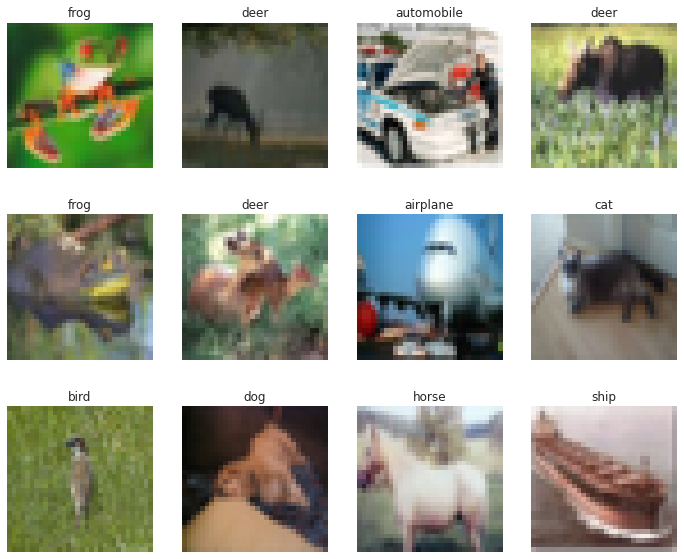

In [67]:
plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.axis('off')
    plt.title(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1, 2, 0]))

#### 3.2.1 Создание модели (Sequential-стиль)

Главной абстракцией в PyTorch является `torch.nn.Module`.  
По сути модуль можно понимать как нейронную сеть или ее какую-то часть. Каждый стандартный слой в PyTorch-е наследуются от `torch.nn.Module`.

Модуль это нечто, что имеет метод `forward` и, возможно, `backward`. Но вообще `backward` является автоматическим (`autograd`).  Кроме того, модуль может содержать в себе другие модули.

In [69]:
print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.
    


Для начала напишем выпрямляющий слой (модуль) Flatten, в PyTorch его нет.

In [0]:
# Специальный слой (модуль), который конвертирует тензор размера [batch, channel, w, h] в тензор [batch, d]
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

Часто, когда нейронная сеть не слишком сложная и последовательная, удобно пользоваться `nn.Sequential()` --- последовательный контейнер из модулей. Модули, входящие в этот контейнер будут выполнятся последовательно один за другим: выход одного подается на вход следующему. 

Теперь напишем саму модель, которая будет возвращать **логиты (logits)**. Логиты - это то, что получается **до применения SoftMax** для получения вероятностей в интервале 0-1. <br>

In [0]:
# Создаем последовательную нейронную сеть
model = nn.Sequential()
model.add_module('flatten', Flatten())
model.add_module('linear_1', nn.Linear(3 * 32 * 32, 64))
model.add_module('relu', nn.ReLU())
model.add_module('linear_2', nn.Linear(64, 10))

In [0]:
# по-другому с именами слоев
model = nn.Sequential(OrderedDict([
    ('flatten', Flatten()),
    ('linear_1', nn.Linear(3 * 32 * 32, 64)),
    ('relu', nn.ReLU()),
    ('linear_2', nn.Linear(64, 10))
]))

In [0]:
# по-другому без имен слоев
model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 64),  # 3072 x 64
    nn.ReLU(),
    nn.Linear(64, 10)
)

*Примечание:* Если вы используете имена для слоев при создании контейнера, то имена должны быть разными, иначе при встрече слоя с уже существующим именем, предыдущий слой с таким именем будет перезаписан на новый. 

У полученной модели можно посмотреть на все ее обучаемые параметры : `model.parameters()`

In [79]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([64, 3072]), torch.Size([64]), torch.Size([10, 64]), torch.Size([10])]


Мы создали модель, то есть научились по какому-либо входу получать выход модели. Чтобы обучить данную модель, нам нужно минимизировать эмпирический риск, то есть функцию потерь ("лосс"). Для этого определим его.

#### 3.2.2 Объявление функции потерь (лосса)

Напишем функцию, которая будет принимать объекты из батча и их отклики и возвращать значение лосса. В качестве лосса будем использовать кросс-энтропию (log-loss или минус лог функция правдоподобия). 

Если не пишите лоссы сами, а используете уже написанные из `torch.nn.functional (F)`, то внимательно читайте (найдите примеры), что они принимают на вход. <br>

Например, `F.cross_entropy` принимает на вход логиты (не вероятности!) и истинные метки классов (не one-hot вектора).

In [0]:
def compute_loss(logits, y_batch):
    logits = torch.FloatTensor(logits)
    y_batch = torch.LongTensor(y_batch)
    return F.cross_entropy(logits, y_batch).mean()

# Если нужно GPU (CUDA)
# def compute_loss(X_batch, y_batch):
#     X_batch = torch.FloatTensor(X_batch).cuda()
#     y_batch = torch.LongTensor(y_batch).cuda()
#     logits = model.cuda()(X_batch)
#     return F.cross_entropy(logits, y_batch).mean()

__Замечание:__ Многие лоссы, в том числе бинарную кросс-энтропию, можно найти и в `torch.nn.functional (F)` в виде функции, и в `torch.nn` в виде отдельного слоя.

#### 3.2.3 Подсчет градиентов по всем обучаемым параметрам

Нейросети обучаются с помощью метода **Backpropagation**. Он объяснялся на лекции, а также с ним вы будете иметь дело в домашнем задании каждый раз, когда будете вычислять backward для каждого конкретного слоя.

<img src="https://srdas.github.io/DLBook/DL_images/backprop2.png" width=600>

*Примечание*: вообще говоря, сам метод обновления весов нейросети не обязан быть gradient-based, каким является backprop. Например, это могут быть эволюционные методы, или относительно недавний Equilibrium propagation, см. [ответ на StackOverflow](https://stackoverflow.com/questions/55287004/are-there-alternatives-to-backpropagation).



#### 3.2.4 PyTorch optimizers

В `torch.optim` лежит много разных уже готовых оптимизаторов таких как SGD, RMSprop, Adam и прочие.

Оптимизатор принимает набор тензоров, по которым он будет считать градиенты и которые будет оптимизировать. Обычно это все параметры модели поэтому обычно передаем `model.parameters()`. <br>
Сначала нам нужно сделать обратный проход посчитав все градиенты, потом мы делаем шаг и уже в конце зануляем градиенты. 

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

# loss.backward()      # обратный проход, считаем градиенты
# opt.step()           # делаем шаг градиентного спуска
# opt.zero_grad()      # зануляем градиенты

Обучение проходит по батчам. Поэтому нам нужно либо самим написать генератор для батчей, либо использовать уже написанный за нас класс `DataLoader`. `DataLoader` принимает в аргументах размер батча и также ему можно сказать, нужно ли перемешивать данные). Пока что сами напишем генератор:

In [0]:
def batch_generator(X, y, batchsize, shuffle=True):
    '''
        Генерирует tuple из батча объектов и их меток
    '''
    indices = np.arange(len(X))
    # во время обучения перемешиваем, во время тестирования - нет
    if shuffle:
        indices = np.random.permutation(indices)
    # идем по всем данным с шагом batchsize
    # возвращаем start: start + batchsize объектов на каждой итерации
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

#### 3.2.5 Цикл обучения нейросети: реализация

Теперь у нас все готово для обучения. 

В фазе обучения мы вызываем метод `train(True)` у модели, чтобы перевести ее в фазу обучения: `model.train(True)`. В фазе тестирования ставим `model.train(False)` (или `model.eval()`).
Это влияет на:
- поведение Dropout слоев
- поведение BatchNorm слоев

Сейчас эти слои мы не используем (будут ниже по ходу ноутбука), но уже держим это в голове.




In [0]:
train_accuracy = []
val_accuracy = []

In [0]:
num_epochs = 100  # общее кол-во полных проходов ("эпох") по обучаемым данным
batch_size = 64  # кол-во объектов в одном батче

history = defaultdict(lambda: defaultdict(list))

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    start_time = time.time()

    model.train(True)  # устанавливаем поведение dropout / batch_norm  в обучение

    # На каждой "эпохе" делаем полный проход по данным
    for X_batch, y_batch in batch_generator(X_train, y_train, batch_size):
        # Обучаемся на батче (одна "итерация" обучения нейросети)
        
        
        ####### ВАШ КОД ЗДЕСЬ #######



    # Подсчитываем лоссы и сохраням в "историю"
    train_loss /= len(X_train) // batch_size
    train_acc /= len(X_train) 
    history['loss']['train'].append(train_loss)
    history['acc']['train'].append(train_acc)
  
    model.train(False) # устанавливаем поведение dropout / batch_norm  в тестирование

    # Полный проход по валидации    
    for X_batch, y_batch in batch_generator(X_val, y_val, batch_size):
        logits = model(torch.FloatTensor(X_batch))
        loss = compute_loss(logits, y_batch)
        val_loss += np.sum(loss.data.numpy())
        y_pred = logits.max(1)[1].data.numpy()
        val_acc += np.sum(y_batch == y_pred)
        val_accuracy.append(np.mean(y_batch == y_pred))

    # Подсчитываем лоссы и сохраням в "историю"
    val_loss /= len(X_val) // batch_size
    val_acc /= len(X_val) 
    history['loss']['val'].append(val_loss)
    history['acc']['val'].append(val_acc)

    # Печатаем результаты после каждой эпохи
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
    print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
    print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

Построим кривые обучения (learning curves):

In [0]:
fig = plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('Лосс', fontsize=15)
plt.plot(history['loss']['train'], label='train')
plt.plot(history['loss']['val'], label='val')
plt.xlabel('эпоха', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.title('Точность', fontsize=15)
plt.plot(history['acc']['train'], label='train')
plt.plot(history['acc']['val'], label='val')
plt.xlabel('эпоха', fontsize=15)
plt.legend();

**Заметки**
* Не забывайте **занулять градиенты** после каждой итерации. 
* Если ваш loss стал `nan`/`inf`, то повыводите то, что происходит на каждой итерации и поймите в каком именно месте проблема. 
* Если ваш loss уменьшался, а потом стал равен `nan`, то попробуйте уменьшить `learning rate`.

#### 3.2.6 Модульный стиль создания нейросети

Сделаем аналогичную модель, но в виде модуля, а не Sequential-модели. Заметим, что здесь наша модель - это модуль, который наследуется от `nn.Module` и содержит в себе другие модули, такие как `nn.Linear`. 

Как было сказано выше, модуль должен обязательно иметь метод `forward()`, который мы сами определяем. Метод `backward()`является необязательным, PyTorch сможет сам понять, что делать при обратном проходе.

In [0]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MySimpleModel, self).__init__()
        # входное количество признаков = высота * ширина * кол-во каналов картинки
        # сейчас 64 нейрона в первом слое
        self.linear1 = nn.Linear(3 * 32 * 32, 64)
        # 10 нейронов во втором слое
        self.linear2 = nn.Linear(64, 10)  # логиты (logits) для 10 классов
        
    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        return x

In [0]:
###### 1. Оберните цикл обучения нейросети в отдельную функцию ######
###### 2. Оберните построение графиков в отдельную функцию    ######
###### 3. Обучите модель в Functional-стиле на CIFAR10     ######
###### 4. Выведите графики функции потерь и метрики качества   ######

In [0]:
...

#### 3.2.7 Dropout

[Dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) $-$ это слой нейронной сети, который зануляет некоторые выходы предыдущего слоя (стоящего перед дропаутом) при подаче в следующий (стоящий после дропаута).

<img src="https://miro.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png" width=500>

Добавьте Dropout, он должен помочь бороться с переобучением. В PyTorch этот слой реализован как `nn.Dropout(p=*value*)`. 

В фазе обучения дропаут делает то, что описаны выше. В фазе тестирования дропаут отключают.

In [0]:
###### ВАШ КОД С DROPOUT-СЕТЬЮ ЗДЕСЬ ######

In [0]:
###### ГРАФИКИ ######

In [0]:
...

Как мы видим, дропаут оказал прямое влияние на способность сети к переобучению $-$ сеть скорее недообучилась. Можно попробовать в сеть параметров (слоев), поставить вероятность дропаута поменьше и достичь "золотой середины".

#### 3.2.8 BatchNorm



[**Batch Normalization (BN)**](http://arxiv.org/abs/1502.03167) $-$ идея batch normalization на самом деле содержится в самом названии $-$ будем нормализовать выход каждого слоя: вычитать из значения каждого признака среднее его значение по текущему батчу и делить на стандартное отклонение. После этого значения признаков умножаются на обучемый параметр `gamma` и прибавляется обучаемый свободный член `beta`, что позволяет "контролировать" среднее значение и дисперсию признаков.

*Forward pass:*

$$
x \in \mathbb{R}^{n \times d}
$$
$$
\mu, \sigma, \gamma, \beta \in \mathbb{R}^{1 \times d}
$$

В фазе обучения  (`self.training == True`) BatchNormalization слой делает то, что описано выше:

$$
\text{BatchNormalization}(x) = \gamma \left( \frac{x - \mu}{\sqrt{\sigma + \varepsilon}} \right) + \beta
$$

$$
\text{BatchNormalization}(x) \in \mathbb{R}^{n \times d}
$$

где $\mu$ и $\sigma$ $-$ среднее и дисперсия значений признаков в $x$ ($\varepsilon$ нужен просто чтобы избежать деление на машинный 0), $\gamma$ и $\beta$ $-$ обучаемые параметры. Также в фазе обучения среднее и дисперсию признаков обновляют (moving average): 

```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```

В фазе тестирования (`self.training == False`) слой нормализует вход `input`, используя посчитанные в фазе обучения `moving_mean` и `moving_variance`. 

На практике BatchNorm обычно ускоряет сходимость при оптимизации, то есть позволяет обучать нейросети быстрее. 

In [0]:
###### ВАШ КОД С BATCHNORM-СЕТЬЮ ЗДЕСЬ ######

In [0]:
###### ГРАФИКИ ######

Какие выводы можно сделать о том, как работает нейросеть без/с `BatchNorm`-слоем?

#### 3.2.9 Playground

In [0]:
###### ЗДЕСЬ МОЖНО МЕНЯТЬ ОПТИМИЗАТОР, ГИПЕРПАРАМЕТРЫ И АРХИТЕКТУРУ И ДОБИВАТЬСЯ ЛУЧШЕГО КАЧЕСТВА ###### 

In [0]:
...

In [0]:
...

Продолжение в Домашнем задании!..